In [ ]:
import google.colab
import os
import sys
import subprocess

REPO_URL = "https://github.com/zivbeker42/llm-guesstimator.git"

bash_setup = f"""
setup_llm_guesstimator() {{
  if [[ -n \"${{COLAB_RELEASE_TAG:-}}\" ]]; then
    local repo_path=\"/content/llm-guesstimator\"
    if [[ ! -d \"$repo_path\" ]]; then
      git clone \"{REPO_URL}\" \"$repo_path\"
    fi
  fi
}}
setup_llm_guesstimator
"""

subprocess.run(["bash", "-lc", bash_setup])

repo_path = "/content/llm-guesstimator" if "google.colab" in sys.modules else os.path.abspath('.')

if repo_path not in sys.path:
    sys.path.append(repo_path)
os.chdir(repo_path)


In [ ]:
!pip install numpy matplotlib pandas


# Transformer Inference Compute Estimates (KV-Cache)

This notebook walks from basic matrix-multiplication complexity to practical, closed-form estimates for **per-token** compute and **time** during autoregressive decoding with **KV-cache**. It includes:

1. A quick refresher on matrix multiplication FLOPs.
2. Per-layer FLOPs for a Transformer block with and without KV-cache.
3. A server-level compute model with **fixed token budget** $(P = S\cdot L)$ (concurrent requests \(S\), context length \(L\)).
4. Plots of total **time per new decoded token** vs. \(L\) and \(S\) for a given GPU peak FLOPs.



## 1) Matrix multiplication complexity (short refresher)

Multiplying an $m \times n$ matrix by an $n \times p$ matrix costs approximately:

$$
\text{FLOPs} \approx 2\,m\,n\,p
$$

counting a multiply and an add as two FLOPs. This is the core building block behind linear layers in Transformers.



## 2) Transformer per-layer FLOPs

We separate each Transformer layer into **attention** and **FFN** parts. Let:

- $L$: sequence length / context length (number of tokens attended over).
- $d$: hidden size.
- $h$: number of attention heads (each head size $(d_h = d/h)$).
- $r$: FFN expansion ratio (usually $(r \approx 4$)).

### 2.1) Without KV-cache (full recomputation)
Processing a length-$L$ sequence **per layer** costs approximately:

$$
\underbrace{8Ld^2}_{Q,K,V,O \text{ projections}} \;+\; \underbrace{4L^2 d}_{QK^\top \text{ and weights}\times V} \;+\; \underbrace{4rLd^2}_{\text{FFN}}
\;=\; (8+4r)Ld^2 \;+\; 4L^2 d.
$$


### 2.2) With KV-cache (incremental decode, per **new token**)
Only the new token's attention is computed (past keys/values are reused). Per layer, per new token:

$$
\underbrace{8d^2}_{Q,K,V,O \text{ for the new token}} \;+\; \underbrace{4Ld}_{qK^\top \text{ and weights}\times V} \;+\; \underbrace{4rd^2}_{\text{FFN}}
\;=\; (8+4r)d^2 \;+\; 4Ld.
$$


We will use this last expression as our **per-request, per-layer, per-token** FLOPs for decoding with KV-cache.



## 3) Server-level model with fixed token budget $(P = S\cdot L)$

Let:
- $S$: number of concurrent requests (each decoding one new token at a step).
- $P = S \cdot L$: fixed "token budget" across the server at each decoding step.

Then total **per-layer** FLOPs across all \(S\) requests is:

$$
\big((8+4r)d^2 + 4Ld\big)\,S
\;=\;
\frac{P(8+4r)d^2}{L} \;+\; 4Pd.
$$


This exhibits a \(1/L\) term plus a constant \(2Pd\) asymptote.

For the full model with $n_\text{layers}$ layers, multiply by $n_\text{layers}$. To convert to **time per token**, divide by **GPU peak FLOPs/sec**.



## 4) Parameters

We define the following parameters in code:

- `r` — FFN expansion ratio (default: 4).
- `d` — hidden size (default: 4096).
- `P` — fixed token budget $P=S\cdot L$ (default: 20,000).
- `n_layers` — number of Transformer layers (default: 64).
- `gpu_flops_per_sec` — GPU peak FLOPs/sec (default: 312e12 for NVIDIA A100 ~312 TFLOPS).

You can adjust these to match your setup.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils.config import (
    S_L_GRID_SETTINGS,
    DEFAULT_DECODE_MODEL_NAME,
    get_hardware_config,
    get_model_config,
    get_workload_config,
)
from utils.math_utils import (
    activation_io_bytes,
    decode_memory_time,
    kv_read_bytes,
    kv_write_bytes,
    time_per_token_from_L,
    time_per_token_from_S,
    weights_bytes,
)

hardware = get_hardware_config()
workload = get_workload_config()
decode_model = get_model_config(DEFAULT_DECODE_MODEL_NAME)

P = workload.total_prompt_tokens
d = decode_model.hidden_size
r = decode_model.expansion_ratio
n_layers = decode_model.num_layers
gpu_flops_per_sec = hardware.flops_per_second

decode_settings = S_L_GRID_SETTINGS["decode"]



## 5) Functions for FLOPs and time
We implement small helpers for clarity and reuse.



## 6) Plot: Time per token vs. $L$ and $S$ (with fixed $P$)

This plots
$$T(L) = \dfrac{n_\text{layers}}{\text{GPU}}\left(\dfrac{P(8+4r)d^2}{L} + 4Pd\right)$$
$$T(S) = \dfrac{n_\text{layers}}{\text{GPU}}\left({S(8+4r)d^2} + 4Pd\right)$$
and the asymptote $\dfrac{n_\text{layers} 4Pd}{\text{GPU}}$.

- Bottom x-axis: $L$ (log scale).
- Top x-axis: $S$ (linear), related by $S = P / L$.

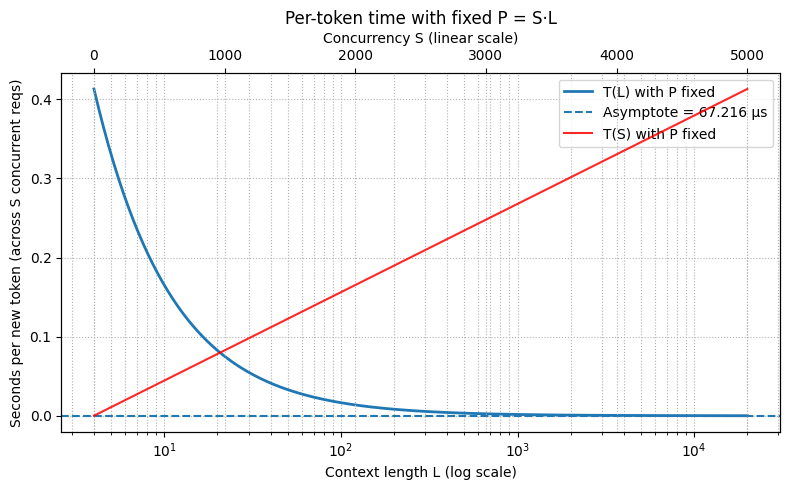

In [10]:
# T(L)
L_vals = np.logspace(
    np.log10(decode_settings["context_min"]),
    np.log10(P),
    int(decode_settings["context_samples"]),
)
T_L = time_per_token_from_L(L_vals, P, decode_model, hardware)
asymptote_time = (4 * P * d * n_layers) / gpu_flops_per_sec

fig, axL = plt.subplots(figsize=(8, 5))
axL.plot(L_vals, T_L, label="T(L) with P fixed", linewidth=2)
axL.axhline(
    asymptote_time,
    linestyle="--",
    label=f"Asymptote = {asymptote_time * 1e6:.3f} µs",
)

# T(S) 
start, stop, num = decode_settings["batch_range"]
S_vals = np.linspace(start, stop, int(num))
T_S = time_per_token_from_S(S_vals, P, decode_model, hardware)


axL.set_xscale("log")
axL.set_xlabel("Context length L (log scale)")
axL.set_ylabel("Seconds per new token (across S concurrent reqs)")
axL.grid(True, which="both", linestyle=":")

axS = axL.twiny()
axS.plot(S_vals, T_S, label="T(S) with P fixed", alpha=0.85, color="red")
axS.set_xlabel("Concurrency S (linear scale)")

lines_L, labels_L = axL.get_legend_handles_labels()
lines_S, labels_S = axS.get_legend_handles_labels()
axL.legend(lines_L + lines_S, labels_L + labels_S, loc="upper right")

plt.title("Per-token time with fixed P = S·L")
plt.tight_layout()
plt.grid(True, which="both", linestyle=":")
plt.show()



## 7) Sample values table

Representative points for \(L\) and \(S\) with the current parameters.


In [ ]:
rows = []
for L in [50, 100, 200, 500, 1000, 2000, 4000, 8000, 10000, 20000]:
    S = P / L
    rows.append({
        "L (context)": L,
        "S (concurrency)": S,
        "Time per token (s)": float(time_per_token_from_L(L, P, decode_model, hardware)),
        "Time per token (ms)": float(time_per_token_from_L(L, P, decode_model, hardware) * 1e3),
    })

for S in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]:
    L = P / S
    rows.append({
        "S (concurrency)": S,
        "L (context)": L,
        "Time per token (s)": float(time_per_token_from_S(S, P, decode_model, hardware)),
        "Time per token (ms)": float(time_per_token_from_S(S, P, decode_model, hardware) * 1e3),
    })

df = pd.DataFrame(rows)
df



# Memory-Bound Estimates for Transformer Decoding (KV-Cache)

This part focuses **only on memory traffic** for per-token latency estimates during autoregressive decoding with KV-cache.
It is designed to be appended to the previous compute-focused notebook.



## Parameters

- $r$ — FFN expansion ratio (default: 4)  
- $d$ — hidden size (default: 4096)  
- $P$ — fixed token budget $P=S\cdot L$ (default: 20,000)  
- $n_\text{layers}$ — number of Transformer layers (default: 64)  
- `dtype_bytes` — bytes per element (default: 2 for FP16/BF16)  
- `BW` — memory bandwidth in Bytes/sec (e.g., A100-80GB $\approx 2.0\times 10^{12}$, A100-40GB $\approx 1.555\times 10^{12}$)



## Plots

- $T_{\text{memory}}(L)$ with fixed $P=S\cdot L$ (log-$L$ axis)  
- $T_{\text{memory}}(S)$ with fixed $P$ (linear-$S$ axis)  

The asymptotic floor at large $L$ (small $S$) is given by **weights + KV read** only.


## Memory Traffic Model

We approximate the per-token memory bytes (across all $S$ concurrent requests at a step) as the sum of:

1. **Weights read (dominant):** $(4+2r)d^2$ params per layer  
   Bytes: $n_\text{layers}\,(4+2r)\,d^2 \cdot \text{dtype\_bytes}$

2. **KV-cache read (constant vs $L$ at fixed $P$):** across $S$ requests per layer we read both $K$ and $V$ for past $L$ tokens  
   Elements: $2SLd = 2Pd$  
   Bytes: $n_\text{layers}\,2Pd \cdot \text{dtype\_bytes}$

3. **KV-cache write (grows with $S$):** writing new $K,V$ for the new token per request  
   Elements: $2Sd$  
   Bytes: $n_\text{layers}\,2Sd \cdot \text{dtype\_bytes}$

4. **Activation I/O (smaller term, but included):** for the six linears (Q,K,V,O and 2xFFN) we use a factor $c_\text{act}=12$  
   Bytes: $n_\text{layers}\,c_\text{act}\,Sd \cdot \text{dtype\_bytes}$

The **memory-bound time** is  
$T_\text{memory} = \dfrac{\text{Bytes}}{\text{total\_BW}}$.

So in total **Memory time:**

$$T_{\text{prefill}}^{\text{memory}}(S,L) = \frac{n_\ell \Big((4+2r) d^2 + (2+c_{\text{act}}) S d + 2 S L d \Big) \, \text{dtype\_bytes}}{BW}$$


## Plots

- $T_{\text{memory}}(L)$ with fixed $P=S\cdot L$ (log-$L$ axis)  
- $T_{\text{memory}}(S)$ with fixed $P$ (linear-$S$ axis)  

The asymptotic floor at large $L$ (small $S$) is given by **weights + KV read** only.


In [7]:
start, stop, num = decode_settings["batch_range"]
S_vals = np.linspace(start, stop, int(num))
L_for_S = P / S_vals
Tmem_S = decode_memory_time(S_vals, L_for_S, decode_model, hardware)

min_context = max(decode_settings["context_min"], P / stop)
L_vals = np.logspace(
    np.log10(min_context),
    np.log10(P),
    int(decode_settings["context_samples"]),
)
S_for_L = P / L_vals
Tmem_L = decode_memory_time(S_for_L, L_vals, decode_model, hardware)

T_asym = float(decode_memory_time(1.0, P, decode_model, hardware))

fig, axL = plt.subplots(figsize=(8, 5))
axL.plot(L_vals, Tmem_L * 1e3, label="T_memory(L) (ms)", linewidth=2)
axL.axhline(T_asym * 1e3, linestyle="--", label=f"Asymptote ≈ {T_asym * 1e3:.2f} ms")
axL.set_xscale("log")
axL.set_xlabel("Context length L (log scale)")
axL.set_ylabel("Estimated memory time per token (ms)")
axL.grid(True, which="both", linestyle=":")

axS = axL.twiny()
axS.plot(S_vals, Tmem_S * 1e3, label="T_memory(S) (ms)", alpha=0.85, color="red")
axS.set_xlabel("Concurrency S (linear scale)")

lines_L, labels_L = axL.get_legend_handles_labels()
lines_S, labels_S = axS.get_legend_handles_labels()
axL.legend(lines_L + lines_S, labels_L + labels_S, loc="upper right")

plt.title("Memory-bound per-token time")
plt.tight_layout()
plt.show()


KeyError: 'batch_range'


## Plots

- $T_{\text{memory}}(L)$ with fixed $S$ (log-$L$ axis)  
- $T_{\text{memory}}(S)$ with fixed $L$ (linear-$S$ axis)  

The asymptotic floor at large $L$ (small $S$) is given by **weights + KV read** only.


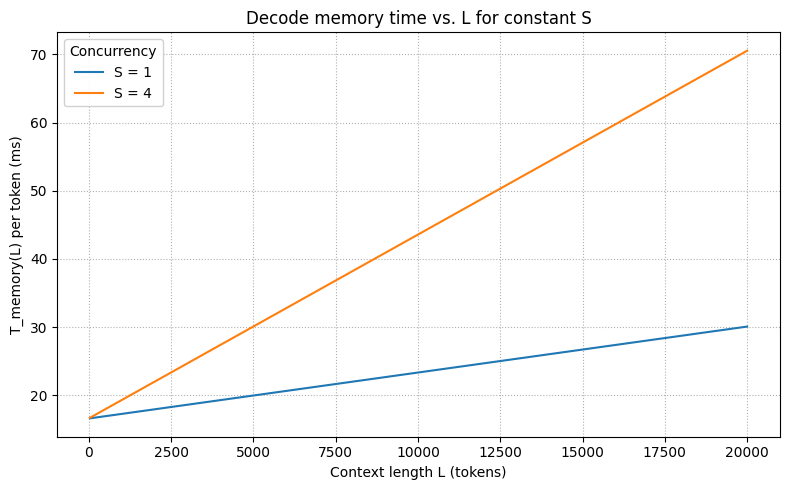

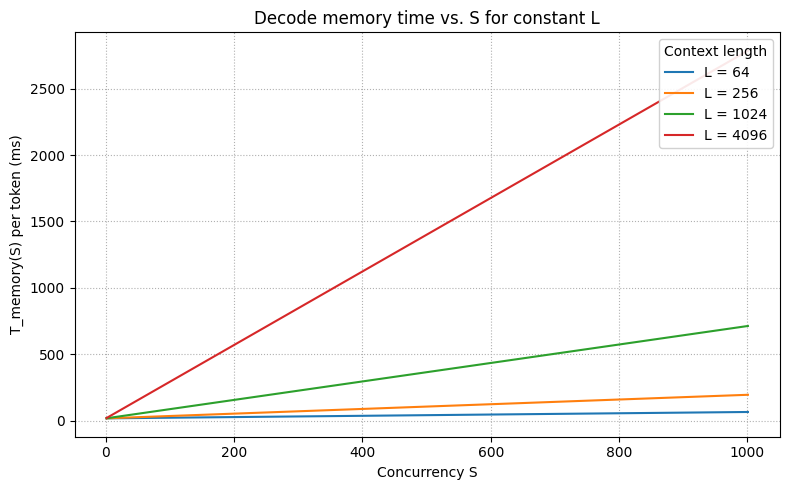

In [5]:
surface_S_start, surface_S_stop, _ = decode_settings["surface_batch_range"]
surface_L_start, surface_L_stop, _ = decode_settings["surface_past_length_range"]

# S_samples = np.array([1, 4, 16, 64, 256, 512], dtype=float)
S_samples = np.array([1, 4], dtype=float)

# L_grid = np.logspace(
#     np.log10(max(decode_settings["context_min"], surface_L_start)),
#     np.log10(surface_L_stop),
#     1000,
# )
L_grid = np.linspace(surface_L_start, surface_L_stop, 1000)
fig, ax = plt.subplots(figsize=(8, 5))
for S_val in S_samples:
    T_vals_ms = decode_memory_time(S_val, L_grid, decode_model, hardware) * 1e3
    ax.plot(L_grid, T_vals_ms, label=f"S = {S_val:g}")

# ax.set_xscale("log")
ax.set_xlabel("Context length L (tokens)")
ax.set_ylabel("T_memory(L) per token (ms)")
ax.set_title("Decode memory time vs. L for constant S")
ax.grid(True, which="both", linestyle=":")
ax.legend(title="Concurrency", loc="upper left", framealpha=0.9)
plt.tight_layout()
plt.show()

# S_grid = np.linspace(surface_S_start, surface_S_stop, 200)
L_samples = np.array([64, 256, 1024, 4096], dtype=float)
# L_samples = np.array([1, 50], dtype=float)

fig, ax = plt.subplots(figsize=(8, 5))
for L_val in L_samples:
    T_vals_ms = decode_memory_time(S_grid, L_val, decode_model, hardware) * 1e3
    ax.plot(S_grid, T_vals_ms, label=f"L = {int(L_val)}")

# ax.set_xscale("log")
ax.set_xlabel("Concurrency S")
ax.set_ylabel("T_memory(S) per token (ms)")
ax.set_title("Decode memory time vs. S for constant L")
ax.grid(True, which="both", linestyle=":")
ax.legend(title="Context length", loc="upper right", framealpha=0.9)
plt.tight_layout()
plt.show()



## Sample Points

A small table of representative $(L,S)$ values to validate magnitudes.


In [ ]:
rows = []
for L in [50, 200, 1000, 4000, 20000]:
    S = P / L
    rows.append({
        "L": L,
        "S": S,
        "Bytes_weights_GB": weights_bytes(decode_model, hardware) / 1e9,
        "Bytes_KV_read_GB": kv_read_bytes(P, decode_model, hardware) / 1e9,
        "Bytes_KV_write_GB": kv_write_bytes(S, decode_model, hardware) / 1e9,
        "Bytes_act_IO_GB": activation_io_bytes(S, decode_model, hardware) / 1e9,
        "T_mem_ms": float(decode_memory_time(S, L, decode_model, hardware) * 1e3),
    })

df = pd.DataFrame(rows)
df


# Combine memory and bandwidth time

In [ ]:
# Install plotly if needed
!pip install plotly nbformat

In [4]:
import numpy as np
import plotly.graph_objs as go

from utils.config import decode_surface_grids, prefill_surface_grids, get_model_config
from utils.math_utils import (
    decode_compute_time,
    decode_memory_time,
    prefill_compute_time,
    prefill_memory_time,
    safe_ratio,
)

model = get_model_config("70B")

# prefill_surface_S, prefill_surface_L = prefill_surface_grids()

# prefill_S_vals = np.array(prefill_surface_S, dtype=float)
# prefill_L_vals = np.arange(
#     prefill_surface_L[0], prefill_surface_L[1] + prefill_surface_L[2], prefill_surface_L[2], dtype=float
# )

# prefill_Sg = prefill_S_vals[None, :]
# prefill_Lg = prefill_L_vals[:, None]

# prefill_T_compute = prefill_compute_time(prefill_Sg, prefill_Lg, prefill_model, hardware)
# prefill_T_memory = prefill_memory_time(prefill_Sg, prefill_Lg, prefill_model, hardware)
# prefill_T_ratio = safe_ratio(prefill_T_compute, prefill_T_memory)
# prefill_T_max = np.maximum(prefill_T_compute, prefill_T_memory)

# prefill_eps = 0.05
# prefill_den = np.maximum(prefill_T_compute, prefill_T_memory)
# prefill_boundary = np.abs(prefill_T_compute - prefill_T_memory) / np.where(prefill_den == 0, 1, prefill_den) <= prefill_eps
# pi, pj = np.where(prefill_boundary)
# prefill_boundary_L = prefill_L_vals[pi]
# prefill_boundary_S = prefill_S_vals[pj]
# prefill_boundary_Z = prefill_T_compute[pi, pj]

def make_surface(x_vals, y_vals, z, boundary_S, boundary_L, boundary_Z, title, zlabel):
    fig = go.Figure(
        data=[
            go.Surface(x=x_vals, y=y_vals, z=z, showscale=True),
            go.Scatter3d(
                x=boundary_S,
                y=boundary_L,
                z=boundary_Z,
                mode="markers",
                marker=dict(size=3, opacity=0.8),
            ),
        ]
    )
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="S (batch size)",
            yaxis_title="L (tokens)",
            zaxis_title=zlabel,
        ),
        margin=dict(l=0, r=0, t=40, b=0),
    )
    fig.show()

# make_surface(
#     prefill_S_vals,
#     prefill_L_vals,
#     prefill_T_compute,
#     prefill_boundary_S,
#     prefill_boundary_L,
#     prefill_boundary_Z,
#     "Prefill — T_compute(S,L)",
#     "Time per prefill step (s)",
# )

# make_surface(
#     prefill_S_vals,
#     prefill_L_vals,
#     prefill_T_memory,
#     prefill_boundary_S,
#     prefill_boundary_L,
#     prefill_boundary_Z,
#     "Prefill — T_memory(S,L)",
#     "Time per prefill step (s)",
# )

# make_surface(
#     prefill_S_vals,
#     prefill_L_vals,
#     prefill_T_ratio,
#     prefill_boundary_S,
#     prefill_boundary_L,
#     prefill_boundary_Z,
#     "Prefill — T_compute/T_memory(S,L)",
#     "Ratio",
# )

decode_surface_S, decode_surface_L = decode_surface_grids()
decode_S_start, decode_S_stop, decode_S_step = decode_surface_S
decode_L_start, decode_L_stop, decode_L_step = decode_surface_L
decode_S_vals = np.arange(decode_S_start, decode_S_stop, decode_S_step, dtype=float)
decode_L_vals = np.arange(decode_L_start, decode_L_stop, decode_L_step, dtype=float)

decode_Sg = decode_S_vals[None, :]
decode_Lg = decode_L_vals[:, None]

decode_T_compute = decode_compute_time(decode_Sg, decode_Lg, model, hardware)
decode_T_memory = decode_memory_time(decode_Sg, decode_Lg, model, hardware)
decode_T_max = np.maximum(decode_T_compute, decode_T_memory)

decode_eps = 0.05
# decode_den = np.maximum(decode_T_compute, decode_T_memory)
# decode_boundary = np.abs(decode_T_compute - decode_T_memory) / np.where(decode_T_max == 0, 1, decode_T_max) <= decode_eps
decode_boundary = np.abs(decode_T_compute - decode_T_memory)  <= decode_eps

di, dj = np.where(decode_boundary)
decode_boundary_L = decode_L_vals[di]
decode_boundary_S = decode_S_vals[dj]
decode_boundary_Z = decode_T_compute[di, dj]

make_surface(
    decode_S_vals,
    decode_L_vals,
    decode_T_compute,
    decode_boundary_S,
    decode_boundary_L,
    decode_boundary_Z,
    "Decode — T_compute(S,L) per token",
    "Time per token (s)",
)

make_surface(
    decode_S_vals,
    decode_L_vals,
    decode_T_memory,
    decode_boundary_S,
    decode_boundary_L,
    decode_boundary_Z,
    "Decode — T_memory(S,L) per token",
    "Time per token (s)",
)

make_surface(
    decode_S_vals,
    decode_L_vals,
    decode_T_max,
    decode_boundary_S,
    decode_boundary_L,
    decode_boundary_Z,
    "Decode — max(T) per token",
    "Time per token (s)",
)


In [ ]:
# citing from flash2.pdf

Benchmark setting: we vary the sequence length from 512, 1k, ..., 16k, and set batch size so that the total
number of tokens is 16k. We set hidden dimension to 2048, and head dimension to be either 64 or 128 (i.e.,
32 heads or 16 heads). To calculate the FLOPs of the forward pass, we use:
4 · seqlen2 · head dimension · number of heads.